## A Simple EKF with IMU Data

## Load data

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import json
import matplotlib.pyplot as plt

# Get environment variables
import sys

sys.path.append("..")  # Add the parent directory of notebooks to sys.path

from lac.plotting import pose_traces
from lac.localization.ekf import EKF
from lac.localization.imu_dynamics import *

%load_ext autoreload
%autoreload 2

In [2]:
casename = "20hz_seed4"
data_path = "../../output/imu/" + casename + ".json"
json_data = json.load(open(f"{data_path}"))

poses = []
imu_data = []

for frame in json_data["frames"]:
    poses.append(np.array(frame["pose"]))
    imu_data.append(np.array(frame["imu"]))

imu_data = np.array(imu_data)

In [3]:
from scipy.spatial.transform import Rotation
from lac.util import skew_symmetric, normalize_rotation_matrix

gt_rotations_euler = np.zeros((len(poses), 3))
imu_rotations_euler = np.zeros((len(poses), 3))

for i in range(len(poses)):
    gt_rotations_euler[i] = Rotation.from_matrix(poses[i][:3, :3]).as_euler("xyz", degrees=False)

gt_translations = np.zeros((len(poses), 6))
for i in range(len(poses)):
    gt_translations[i, :3] = poses[i][:3, 3]
    if i > 0:
        dt = json_data["frames"][i]["mission_time"] - json_data["frames"][i - 1]["mission_time"]
        gt_translations[i, 3:] = (gt_translations[i, :3] - gt_translations[i - 1, :3]) / dt

In [ ]:
def rot_from_rpy(roll, pitch, yaw):
    return np.array(
        [
            [np.cos(yaw)*np.cos(pitch), np.cos(pitch)*np.sin(yaw), -np.sin(pitch)],
            [np.cos(yaw)*np.sin(roll)*np.sin(pitch)-np.cos(roll)*np.sin(yaw), np.cos(roll)*np.cos(yaw)+np.sin(roll)*np.sin(yaw)*np.sin(pitch), np.cos(pitch)*np.sin(roll)],
            [np.sin(roll)*np.sin(yaw)+np.cos(roll)*np.cos(yaw)*np.sin(pitch), np.cos(roll)*np.sin(yaw)*np.sin(pitch)-np.cos(yaw)*np.sin(roll), np.cos(roll)*np.cos(pitch)]
        ]
    )

In [ ]:
# Get Initial states
R_0 = poses[0][:3, :3]

imu_rotations = []
imu_rotations.append(R_0)

v0 = np.zeros(3)
# v0 = (gt_translations[1, :3] - gt_translations[0, :3]) / (json_data["frames"][1]["mission_time"] - json_data["frames"][0]["mission_time"])

x0 = np.hstack((gt_translations[0, :3], v0, gt_rotations_euler[0])).T

print("r0 :", gt_translations[0, :3])
print("v0 :", v0)
print("angle0 :", gt_rotations_euler[0])

init_r = 0.001
init_v = 0.01
init_angle = 0.001
P0 = np.diag(np.hstack((np.ones(3) * init_r * init_r, np.ones(3) * init_v * init_v, np.ones(3) * init_angle * init_angle)))

# Process noise
Q_r = 0.00 **2
Q_v = 0.00 **2
Q_angle = 0.00005 **2
Q = np.diag(np.hstack((np.ones(3) * Q_r, np.ones(3) * Q_v, np.ones(3) * Q_angle)))

ekf = EKF(x0, P0)

x_store = np.zeros((len(poses), 9))
P_store = np.zeros((len(poses), 9, 9))

x_store[0] = ekf.x
P_store[0] = ekf.P
for i in range(1, len(poses)):
    dt = json_data["frames"][i]["mission_time"] - json_data["frames"][i - 1]["mission_time"]
    a_k = imu_data[i][:3]
    omega_k = imu_data[i][3:]

    dyn_func = lambda x: propagate_state(x, a_k, omega_k, dt, with_stm=True, use_numdiff=False)
    ekf.predict(dyn_func, Q)

    x_store[i] = ekf.x
    P_store[i] = ekf.P


r0 : [-9.38848877  2.8519876   1.86459863]
v0 : [ 0.00926971 -0.00997543 -0.00670195]
angle0 : [0.08498921 0.02596164 0.26355474]


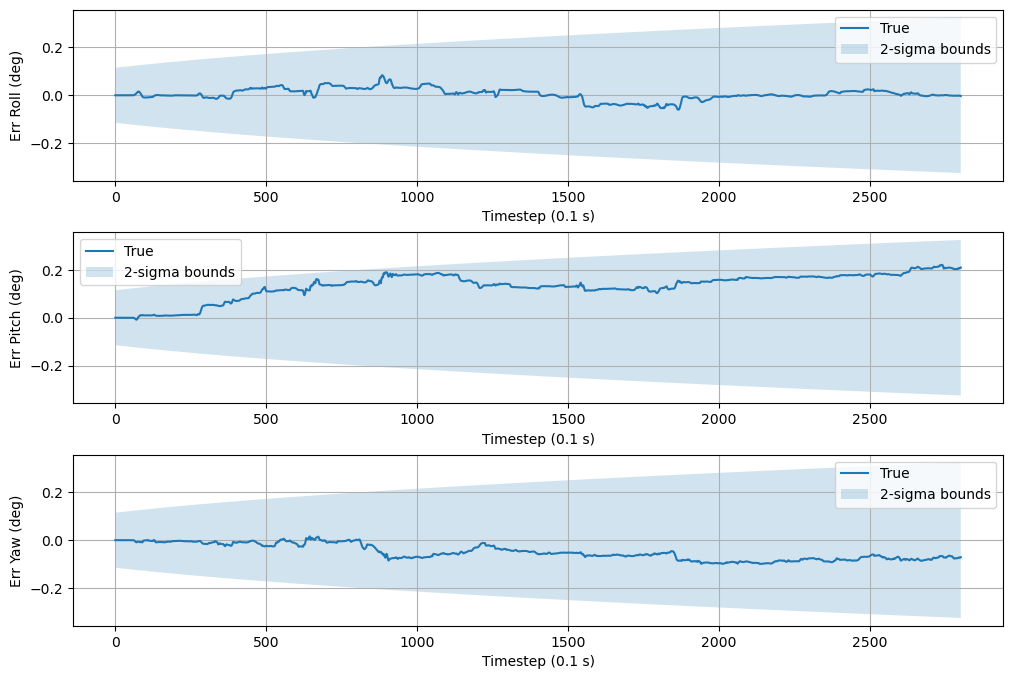

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
RAD2DEG = 180 / np.pi
pos_labels = ["Err Roll (deg)", "Err Pitch (deg)", "Err Yaw (deg)"]
for i in range(3):
    ax = axes[i]
    ax.plot((gt_rotations_euler[:, i] - x_store[:, 6+i]) * RAD2DEG, label="True")
    # plot 3-sigma bounds
    ax.fill_between(
        np.arange(len(poses)),
        - 2 * np.sqrt(P_store[:, 6+i, 6+i]) * RAD2DEG,
        + 2 * np.sqrt(P_store[:, 6+i, 6+i]) * RAD2DEG,
        alpha=0.2,
        label="2-sigma bounds"
    )
    ax.legend()
    ax.grid()
    ax.set_xlabel("Timestep (0.1 s)")
    ax.set_ylabel(f"{pos_labels[i]}")
plt.subplots_adjust(wspace=0.0, hspace=0.3)

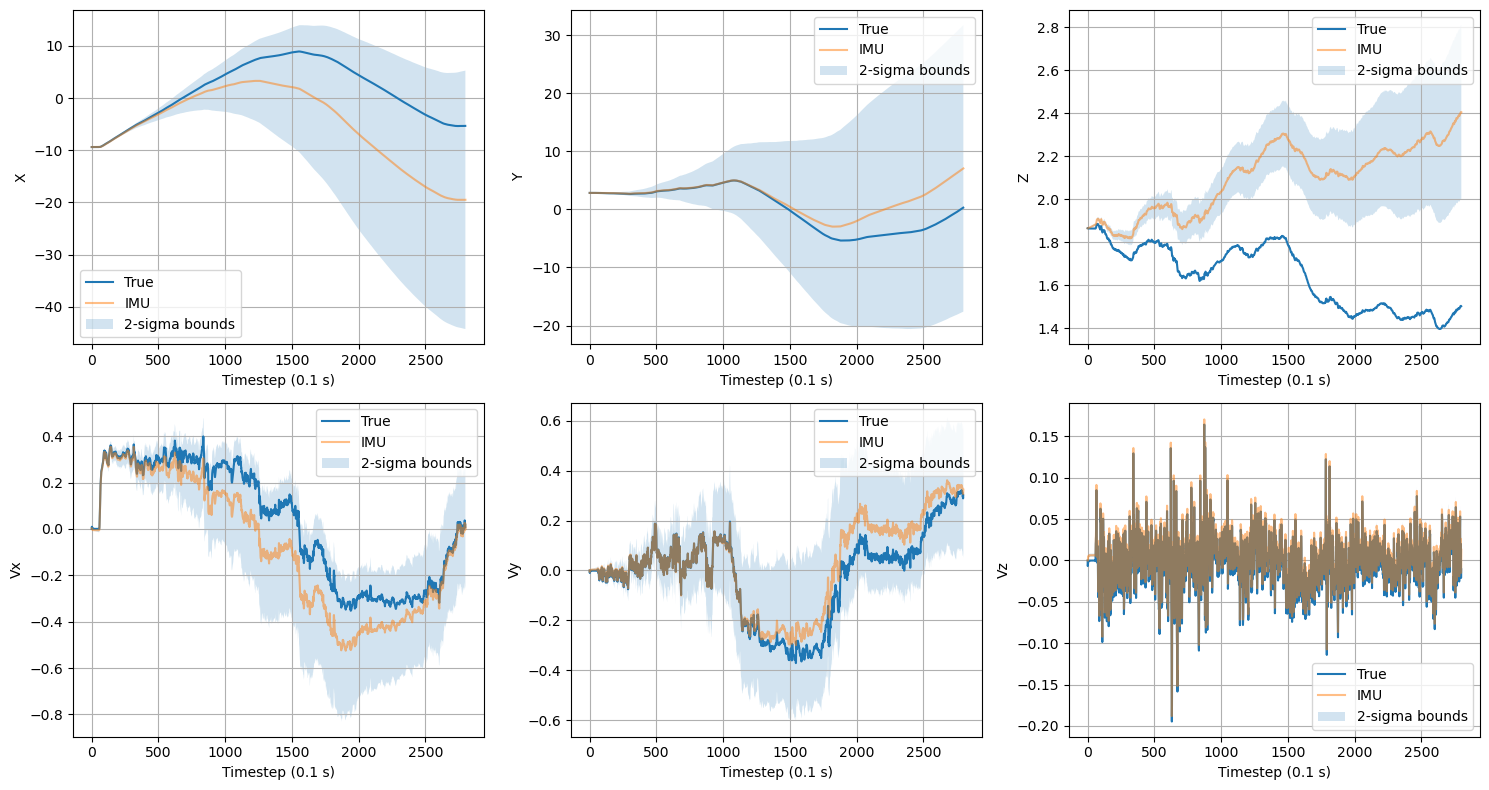

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
pos_labels = ["X", "Y", "Z", "Vx", "Vy", "Vz"]

N = -1

for i in range(6):
    ax = axes.flatten()[i]
    ax.plot(gt_translations[:N, i], label="True")
    ax.plot(x_store[:, i], label="IMU", alpha=0.5)
    # plot 3-sigma bounds
    ax.fill_between(
        np.arange(len(poses)),
        x_store[:, i] - 2 * np.sqrt(P_store[:, i, i]),
        x_store[:, i] + 2 * np.sqrt(P_store[:, i, i]),
        alpha=0.2,
        label="2-sigma bounds",
    )
    ax.legend()
    ax.grid()
    ax.set_xlabel("Timestep (0.1 s)")
    ax.set_ylabel(f"{pos_labels[i]}")

plt.tight_layout()
plt.show()